

To do
* add in various try, if statements to catch common errors
* Try and download all bsrn data
* Needs to check if the file exists on the FTP server before creating a local file and attempts to download it. It should remove this filename from the list, such that it does not try to read it
* What's the difference between parse and read?
* Add check for file extension in read_bsrn
* Return meta-data


The "station-to-archive" file format is described in the [technical plan for BSRN data](https://bsrn.awi.de/fileadmin/user_upload/bsrn.awi.de/Publications/Hegner.pdf) from 1998 and in the [updated version](https://bsrn.awi.de/fileadmin/user_upload/bsrn.awi.de/Publications/gcos-174.pdf) from 2013

Notes
* requests library doesn't support ftp links

In [1]:
# Due to the file structure, it is necessary to read every other row seperately
# This can either be done by a lambda function passed to pd.read_csv or by passing a modified file object

In [36]:
# Python is able to open compressed files such as gzipped files, by default pd.read_csv infers the compression type
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gzip
from collections import OrderedDict
import os

def read_bsrn(filename):
    """Read in a monthly BSRN file. The BSRN network is described in [1]
    
    Parameters
    ----------
    filename: str
        Filepath or url.
    
    Returns
    -------
    Tuple of the form (data, metadata).

    data: Dataframe
        Dataframe with the fields found below.
    metadata: dict
        Site metadata included in the file.
    
    Notes
    -----
    Metadata dictionary includes the following fields:

    ===============  ======  ===============
    Key              Format  Description
    ===============  ======  ===============
    station          String  site name
    latitude         Float   site latitude
    longitude        Float   site longitude
    elevation        Int     site elevation
    tz               String  Timezone (UTC)
    ===============  ======  ===============

    Dataframe includes the following fields:

    =======================  ======  ==========================================
    Key                      Format  Description
    =======================  ======  ==========================================
    day                      int     Day of the month 1-31
    minute                   int     Minute of the day 0-1439
    ghi                      float   Global horizontal irradiance [W/m^2]
    ghi_std                  float   Global horizontal irradiance [W/m^2]
    ghi_min                  float   Global horizontal irradiance [W/m^2]
    ghi_max                  float   Global horizontal irradiance [W/m^2]
    dni                      float   Direct normal irradiance [W/m^2]
    dni_std                  float   Direct normal irradiance [W/m^2]
    dni_min                  float   Direct normal irradiance [W/m^2]
    dni_max                  float   Direct normal irradiance [W/m^2]
    dhi                      float   Diffuse horizontal irradiance [W/m^2]
    dhi_std                  float   Diffuse horizontal irradiance [W/m^2]
    dhi_min                  float   Diffuse horizontal irradiance [W/m^2]
    dhi_max                  float   Diffuse horizontal irradiance [W/m^2]
    dhi                      float   Diffuse horizontal irradiance [W/m^2]
    dhi_std                  float   Diffuse horizontal irradiance [W/m^2]
    dhi_min                  float   Diffuse horizontal irradiance [W/m^2]
    dhi_max                  float   Diffuse horizontal irradiance [W/m^2]
    air_temperature          float   
    relative_humidity        float   
    pressure                 float   
    =======================  ======  ==========================================

    References
    ----------
    .. [1] World Radiation Monitoring Center - Baseline Surface Radiation Network (BSRN)
       `BSRN homepage <https:/https://bsrn.awi.de/>`_

    """
    
    # Read file and store the starting line number for each each section
    line_no_dict = OrderedDict()
    if str(filename).endswith('.gz'): # if file is a gzipped file
        with gzip.open(filename,'rt') as f:
            for num, line in enumerate(f):
                if ('*U' in line) or ('*C' in line):
                    line_no_dict[line.splitlines()[0]] = num
    else:
        with open(filename, 'r') as f:
            for num, line in enumerate(f):
                if ('*U' in line) or ('*C' in line):
                    line_no_dict[line.splitlines()[0]] = num
                    
    # Get line numbers for the data set
    line_no_dict_keys = list(line_no_dict.keys())
    data_id = [k for k in line_no_dict_keys if ('*C0100' in k) or ('*U0100' in k)][0] # tag for start of data sets, either *C0100 or *U0100
    start_row = line_no_dict[data_id] + 1 # First line number of data
    if data_id == line_no_dict_keys[-1]: # check if the dataset is the last dataset
        end_row = num
    else:
        end_row = line_no_dict[line_no_dict_keys[line_no_dict_keys.index(data_id)+1]] # Last line number of data # should there be -1?
    nrows = end_row-start_row

    # Read file as a fixed width file (fwf)
    colspecs = [(0,3),(4,9),(10,16),(17,22),(23,27),(28,32),(33,39),(40,45),(46,50),(51,55),(56,64),(65,70),(71,75)]
    data = pd.read_fwf(filename, skiprows=start_row, nrows=nrows, header=None, colspecs=colspecs, na_values=[-999.0, -99.9])
    
    # Assign multi-index and unstack DataFrame, such that each variable has a seperate column
    data = data.set_index([data.index//2, data.index%2]).unstack(level=1).swaplevel(i=0, j=1, axis='columns')
    
    # Sort columns to match original order
    data = data.reindex(sorted(data.columns), axis=1)

    # Assign column names
    data.columns = ['day','minute',
                    'ghi','ghi_std','ghi_min','ghi_max',
                    'dni','dni_std','dni_min','dni_max','empty0','empty1','empty2','empty3','empty4',
                    'dhi','dhi_std','dhi_min','dhi_max',
                    'lwd','lwd_std','lwd_min','lwd_max',
                    'air_temperature','relative_humidity','pressure']
    
    # Change day and minute type to integer and drop empty columns
    data['day'] = data['day'].astype('Int64')
    data['minute'] = data['minute'].astype('Int64')
    data = data.drop(['empty0','empty1','empty2','empty3','empty4'], axis='columns')

    # Set datetime index
    basename = os.path.basename(filename)
    data.index = pd.to_datetime(basename[3:7], format='%m%y') + pd.to_timedelta(data['day']-1, unit='d') + pd.to_timedelta(data['minute'], unit='min')

    # Sort index and add missing timesteps
    data = data.sort_index().asfreq('1min')
    meta = {}
    return data, meta

Test the *read_bsrn* function with a local file.

Index(['day', 'minute', 'ghi', 'ghi_std', 'ghi_min', 'ghi_max', 'dni',
       'dni_std', 'dni_min', 'dni_max', 'dhi', 'dhi_std', 'dhi_min', 'dhi_max',
       'lwd', 'lwd_std', 'lwd_min', 'lwd_max', 'air_temperature',
       'relative_humidity', 'pressure'],
      dtype='object')

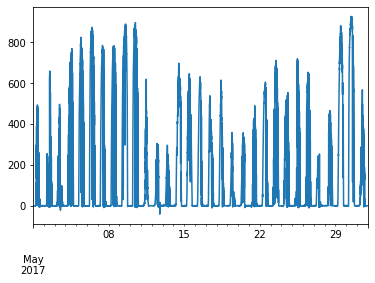

In [37]:
filename = 'BSRN_data_files/tam0517.dat.gz'
data, meta = read_bsrn(filename)
data['dni'].plot()
data.columns

In [9]:
import glob
import os
import ftplib
import pandas as pd
import datetime as dt
from pandas._libs.tslibs import Timestamp

def get_bsrn(start, end, stations, username, password, ftp_url='ftp.bsrn.awi.de', local_path=None):
    """
    Download BSRN from the ftp server

    Parameters
    ----------
    local_path : str
        path of where to save downloaded .gz files
    stations : str or list-like
        3-letter acronym of requested BSRN stations
    startdate : str or datetime-like
        UTC date
    enddate : str or datetime-like
        UTC date

    Returns
    -------
    data : pandas.DataFrame
        timeseries data from BSRN archive
    meta : list or dict
        meta data, ``None`` for basic

    Notes
    -----

    Examples
    --------
    
    References
    ----------

    .. [1] 
    .. [2] 
    """
   
    if start is not None:
        start = Timestamp(start)
    if end is not None:
        end = Timestamp(end)
    if type(stations) == str:
        stations = [stations]
    if local_path is None:
        local_path = os.getcwd()

    # Generate list of months and years to download
    months = (end.year-start.year)*12 + (end.month - start.month) + 1
    month_year_list = pd.date_range(start, periods=months, freq='M').strftime("%m%y").tolist()

    filenames = []
    for station in stations:
        for month_year_str in month_year_list:
            filenames.append(station.lower()+month_year_str + '.dat.gz')

    existing_files = [os.path.basename(p) for p in glob.glob(os.path.join(local_path,'*'))]
    missing_files = [f for f in filenames if f not in existing_files]
        
    with ftplib.FTP(ftp_url, user, passwd) as ftp:
        for filename in missing_files:
            ftp.cwd('/{}'.format(filename[:3])) # change to station sub-directory
            if filename in ftp.nlst(): # check if file exists on the ftp server
                with open(os.path.join(local_path, filename), 'wb') as f: # create local file
                    ftp.retrbinary('RETR ' + filename, f.write) # retrieve data and write to local file
            else:
                print('File {} does not exists on ftp server'.format(filename))
                filenames.remove(filename) # remove the filename from the list of filenames to read

    # Read data and concatenate to one DataFrame with Multi-Index
    dfs = []
    stations_avaiable = set([f[:3] for f in filenames])
    for station in stations_avaiable:
        dfi = []
        station_files = [f for f in filenames if station in f]
        for filename in station_files:
            data, meta = read_bsrn(os.path.join(local_path, filename))
            data.columns = [[filename[:3]]*len(data.columns), data.columns]
            dfi.append(data)
        dfs.append(pd.concat(dfi)) # Cocatenate all months one station at a time

    df = pd.concat(dfs, axis=1) # Concatenate the individual stations together

    return df

<br>

Test of *bsrn_get* function

In [24]:
start = dt.datetime(2017,1,1)
end = dt.datetime(2017,3,1)
stations = ['TAM','PAY','CNR']
ftp_url = 'ftp.bsrn.awi.de'
user = 'bsrnftp'
passwd = 'bsrn1'

df = get_bsrn(start, end, stations, user, passwd, local_path='BSRN_data_files')
df.head()

pay                                                   \
                     day minute  ghi ghi_std ghi_min ghi_max  dni dni_std   
2017-01-01 00:00:00  1.0    0.0  NaN    99.9     999     999  NaN    99.9   
2017-01-01 00:01:00  1.0    1.0  0.0     0.1       0       0  0.0     0.0   
2017-01-01 00:02:00  1.0    2.0  0.0     0.1       0       0  0.0     0.0   
2017-01-01 00:03:00  1.0    3.0  0.0     0.1       0       0  0.0     0.0   
2017-01-01 00:04:00  1.0    4.0  0.0     0.0       0       0  0.0     0.0   

                                     ...     cnr                         \
                    dni_min dni_max  ... dhi_std dhi_min dhi_max    lwd   
2017-01-01 00:00:00     999     999  ...     0.1    -1.0    -1.0  313.0   
2017-01-01 00:01:00       0       0  ...     0.1    -1.0    -1.0  313.0   
2017-01-01 00:02:00       0       0  ...     0.1    -1.0    -1.0  313.0   
2017-01-01 00:03:00       0       0  ...     0.1    -1.0     0.0  313.0   
2017-01-01 00:04:00       0       0  ...     0.1    -1.0     0.0  312.0   

                                                                               \
                    lwd_std lwd_min lwd_max air_temperature relative_humidity   
2017-01-01 00:00:00     0.1   312.0   313.0             0.3               3.3   
2017-01-01 00:01:00     0.1   312.0   313.0             0.3               3.3   
2017-01-01 00:02:00     0.1   312.0   313.0             0.3               3.3   
2017-01-01 00:03:00     0.1   312.0   313.0             0.3               3.3   
2017-01-01 00:04:00     0.1   312.0   313.0             0.3               3.3   

                              
                    pressure  
2017-01-01 00:00:00    975.0  
2017-01-01 00:01:00    975.0  
2017-01-01 00:02:00    975.0  
2017-01-01 00:03:00    975.0  
2017-01-01 00:04:00    975.0  

[5 rows x 63 columns]

<br>
Plot bsrn data from multiple stations.

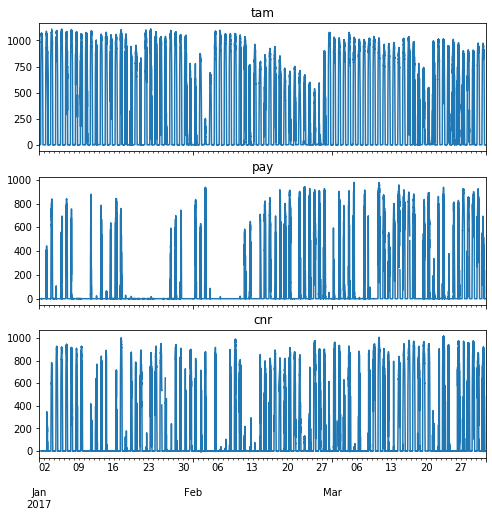

In [33]:
stations = list(df.columns.levels[0])[::-1]
fig, axes = plt.subplots(nrows=len(stations), figsize=(8,8), sharex=True)
for i, s in enumerate(stations):
    df[(s,'dni')].plot(ax=axes[i])
    axes[i].set_title(s)

<br>

### BSRN meta-data

In [27]:
bsrn_meta = pd.read_html('https://dataportals.pangaea.de/bsrn/', keep_default_na=False)[0].iloc[:-2]
bsrn_meta = bsrn_meta.replace('X',True).replace('',False)
bsrn_meta.tail()

,Station,Short name,Station scientist currently in charge,1992,1993,1994,1995,1996,1997,1998,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,All
68,Tiksi,TIK,Vasilii Kustov (kustov@aari.ru),False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,False,False,True
69,Tiruvallur,TIR,Prasun Kumar (prasun.niwe@nic.in),False,False,False,False,False,False,False,...,False,False,True,True,True,True,True,True,False,True
70,Toravere,TOR,Ain Kallis (kallis@aai.ee),False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
71,Xianghe,XIA,** Station closed in 2016 **,False,False,False,False,False,False,False,...,True,True,True,True,False,False,False,False,False,True
72,Yushan,YUS,Kun-Wei Lin (adenins@cwb.gov.tw),False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,True,True
